In [1]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [3]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [4]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [5]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 128)

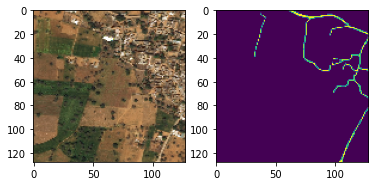

In [6]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [7]:
len(framObjTrain['img'])

6226

In [ ]:
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 83, verbose = 1)

Epoch 1/83
195/195 [==============================] - 30s 93ms/step - loss: 0.2558 - accuracy: 0.9381
Epoch 2/83
195/195 [==============================] - 17s 88ms/step - loss: 0.1575 - accuracy: 0.9533
Epoch 3/83
195/195 [==============================] - 17s 89ms/step - loss: 0.1376 - accuracy: 0.9534
Epoch 4/83
195/195 [==============================] - 17s 89ms/step - loss: 0.1261 - accuracy: 0.9545
Epoch 5/83
195/195 [==============================] - 18s 90ms/step - loss: 0.1181 - accuracy: 0.9559
Epoch 6/83
195/195 [==============================] - 18s 91ms/step - loss: 0.1123 - accuracy: 0.9571
Epoch 7/83
  2/195 [..............................] - ETA: 17s - loss: 0.1166 - accuracy: 0.9536

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
def predict16 (valMap, model, shape = 128):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    
  

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

In [ ]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [ ]:
Plotter(actuals[13], sixteenPrediction[13][:,:,0], masks[13])

In [ ]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

In [ ]:
Plotter(actuals[15], sixteenPrediction[15][:,:,0], masks[15])

In [ ]:
unet.save('MapSegmentationGenerator.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('MapSegmentationGenerator.h5')

In [ ]:
import numpy as np
from PIL import Image

# Load testing images
test_image1 = np.array(Image.open('/kaggle/input/test-dataset11/vit1 (1).jpg').resize((128, 128)))  # Adjust t/kaggle/input/test-dataset11/vit1 (1).jpghe path and format accordingly
test_image2 = np.array(Image.open('/kaggle/input/test-dataset11/vit2 (1).jpg').resize((128, 128)))
test_image3 = np.array(Image.open('/kaggle/input/test-dataset11/vit3 (1).jpg').resize((128, 128)))
test_image4 = np.array(Image.open('/kaggle/input/test-dataset11/vit4 (1).jpg').resize((128, 128)))

# Preprocess the testing images
# Ensure the preprocessing steps match what you did during training

# Make predictions
predictions1 = model.predict(np.expand_dims(test_image1, axis=0))
predictions2 = model.predict(np.expand_dims(test_image2, axis=0))
predictions3 = model.predict(np.expand_dims(test_image3, axis=0))
predictions4 = model.predict(np.expand_dims(test_image4, axis=0))


In [ ]:
predictions1[0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_results(predicted_mask, original_image, save_path=None):
    # Convert to NumPy arrays and ensure numeric data types
    original_image = np.array(original_image).astype(np.uint8)
    predicted_mask = np.array(predicted_mask).astype(np.float32)

    # Display the original image
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(predicted_mask), vmin=0, vmax=1)  # Adjust vmin and vmax based on your data range
    plt.title('Predicted Mask')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [ ]:
# Visualize or save the results
im1 = Image.open('/kaggle/input/test-dataset11/vit1 (1).jpg')
im2 = Image.open('/kaggle/input/test-dataset11/vit2 (1).jpg')
im3 = Image.open('/kaggle/input/test-dataset11/vit3 (1).jpg')
im4 = Image.open('/kaggle/input/test-dataset11/vit4 (1).jpg')
visualize_results(predictions1, im1)
visualize_results(predictions2, im2)
visualize_results(predictions3, im3)
visualize_results(predictions4, im4)